In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
pandas 0.23.4
torch 1.4.0


In [2]:
import torch

import os, wget
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [3]:
import json

In [4]:
from ML.lstm_torch import LSTM_Predictor, set_seq, train_lstm, LSTM_data_loader

import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [7]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

In [8]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [9]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [10]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [11]:
tdf = pd.read_csv('/Users/danielkeogh/projects/time-series-covid/time_series_19-covid-Confirmed.csv')

In [12]:
with open('./data/us-states.json', 'r') as f:
    us_states = json.load(f)
    
state_abrs = [x['id'] for x in us_states['features']]

state_mapper_lst = [{x['properties']['name']:x['id']} for x in us_states['features']]

state_mapper_lst
state_mapper = {}
for s in state_mapper_lst:
    state_mapper.update(s)

In [36]:
test_dl = LSTM_data_loader(df=tdf,
                          region_abr='WA',
                          country='US',
                          region_list=state_abrs,
                          state_mapper=state_mapper,
                          sequence_lenth=3)

In [37]:
test_dl.df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,50,53,59,70,75,82,114,147,177
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,502,511,581,639,639,701,773,839,825,878
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,150,160,178,178,200,212,226,243,266
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,99,117,129,149,149,197,238,428,566,673


In [38]:
test_dl.subset_df()
test_dl.transform_df_datetime()
test_dl.gen_data_sets(test_data_size=5)

X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

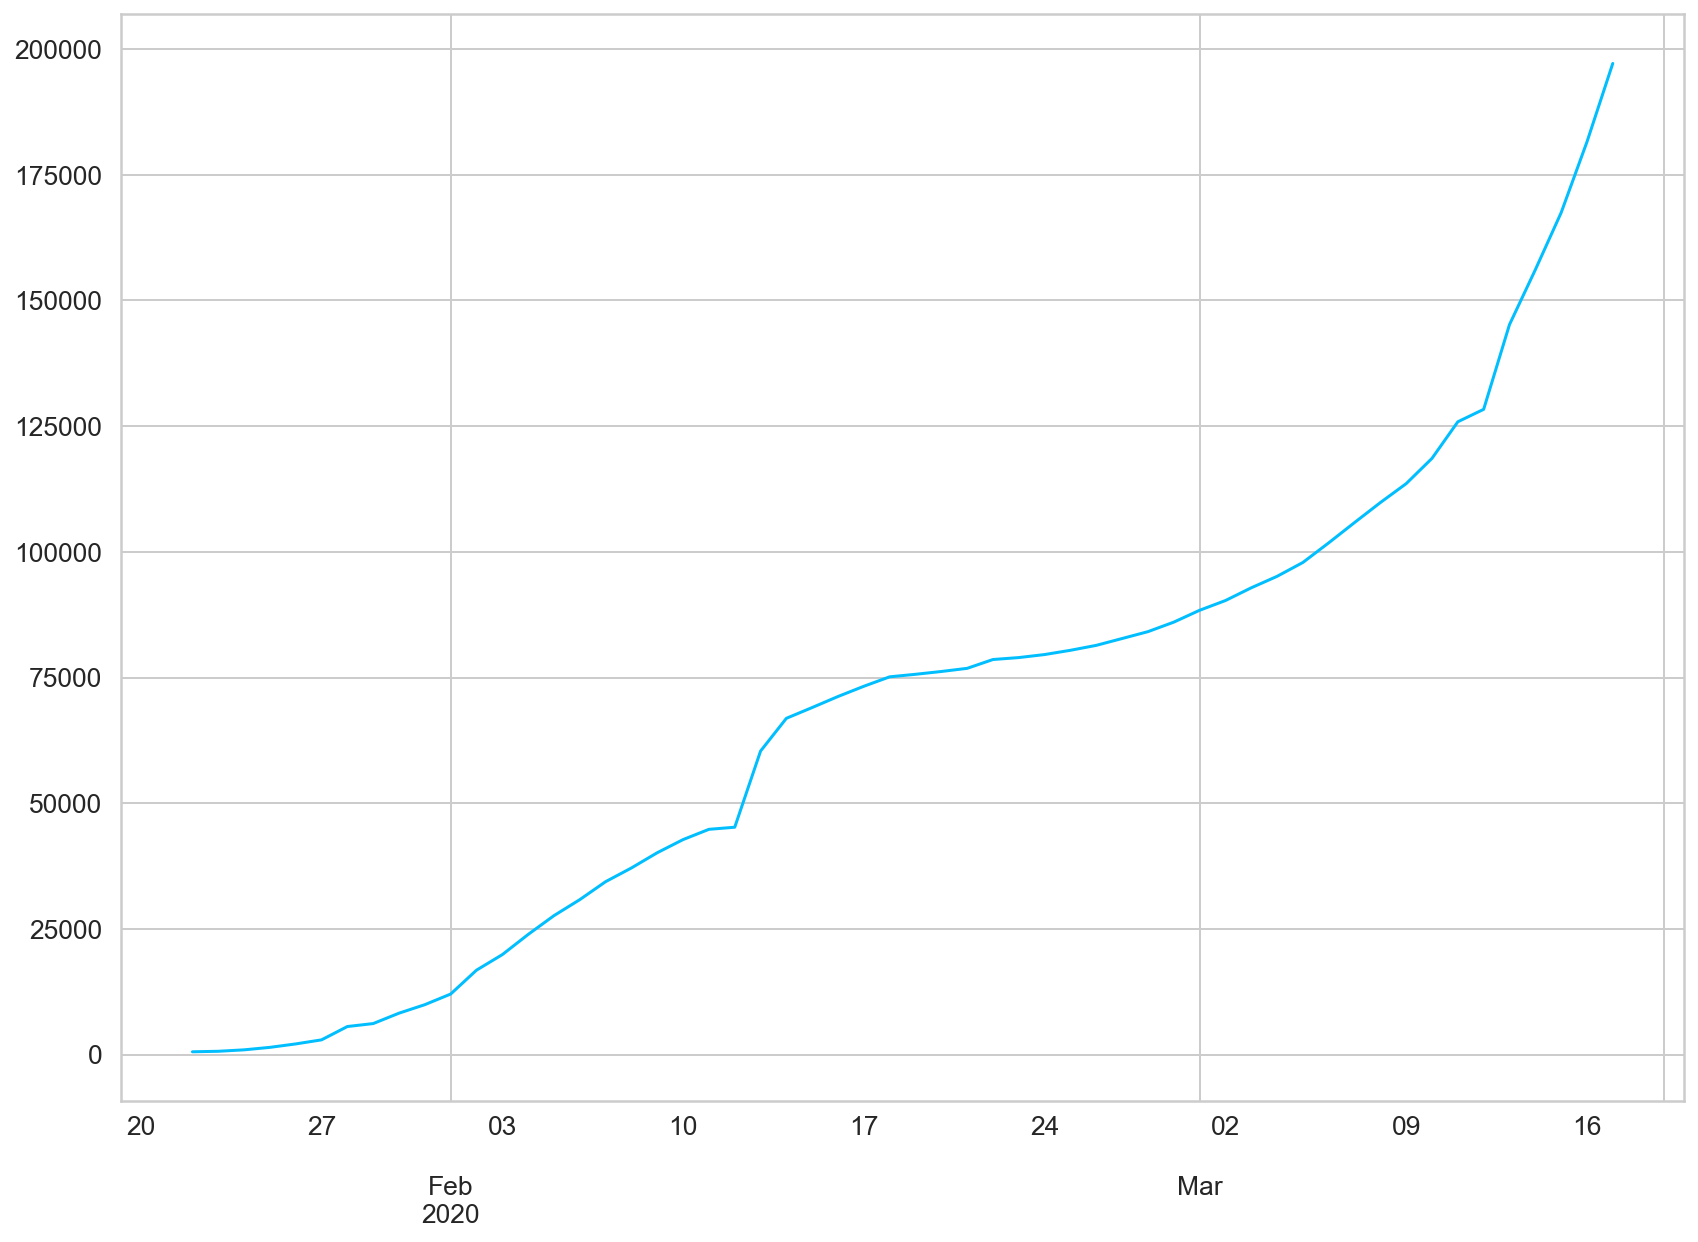

In [17]:
test_dl.df.plot()

In [18]:
test_dl.gen_data_sets(test_data_size=5)

In [22]:
test_dl.test_data.shape

(5, 1)

In [28]:
X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

In [29]:
X_test, y_test = test_dl.set_seq(train=False)

In [30]:
X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [31]:
y_test.shape

torch.Size([1, 1])

In [32]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.3
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [33]:
def train_model(model, train_data, train_labels, test_data=None,test_labels=None, n_epochs=300):
    
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

  train_hist = np.zeros(n_epochs)
  test_hist = np.zeros(n_epochs)

  for t in range(n_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [34]:
test_dl.sequence_lenth

3

In [ ]:
data_saver = {}

for s in state_abrs:
    print(s)
    
    # Instanial our loader / transformer
    test_dl = LSTM_data_loader(df=tdf,
                          region_abr=s,
                          country='US',
                          region_list=state_abrs,
                          state_mapper=state_mapper,
                          sequence_lenth=3)
    
    test_dl.subset_df()
    test_dl.transform_df_datetime()
    test_dl.gen_data_sets(test_data_size=5)

    X_train, y_train = test_dl.set_seq()
    X_test, y_test = test_dl.set_seq(train=False)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    
    model = CoronaVirusPredictor(
      n_features=1,
      n_hidden=512,
      seq_len=test_dl.sequence_lenth,
      n_layers=2
    )
    
    model, train_hist, test_hist = train_model(
      model,
      X_train,
      y_train,
      X_test,
      y_test
    )
    
    with torch.no_grad():
        test_seq = X_test[:1]
        preds = []
        for _ in range(len(X_test)):
            y_test_pred = model(test_seq)
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(1, test_dl.sequence_lenth, 1).float()
        
    true_cases = test_dl.scaler.inverse_transform(
        np.expand_dims(y_test.flatten().numpy(), axis=0)
    ).flatten()

    predicted_cases = test_dl.scaler.inverse_transform(
      np.expand_dims(preds, axis=0)
    ).flatten()
    
    data_saver[s] = {
        'train_hist' : train_hist,
        'test_hist' : test_hist,
        'xtrain' : X_train,
        'xtest' : X_test,
        'ytrain' : y_test,
        'ytest' : y_test,
        'true_cases' : true_cases,
        'predicted_cases' : predicted_cases
    }
    
#     print(data_saver)
    

AL
Epoch 0 train loss: 0.0025551083963364363 test loss: 840.7509155273438
Epoch 10 train loss: 4.010730117443018e-05 test loss: 841.1318969726562
Epoch 20 train loss: 7.249724149005488e-05 test loss: 840.7929077148438
Epoch 30 train loss: 2.9153761715861037e-05 test loss: 841.001220703125
Epoch 40 train loss: 5.052225969848223e-05 test loss: 841.0662841796875
Epoch 50 train loss: 2.18679997487925e-05 test loss: 841.0452270507812
Epoch 60 train loss: 2.23827337322291e-05 test loss: 840.9663696289062
Epoch 70 train loss: 1.763032742019277e-05 test loss: 841.1888427734375
Epoch 80 train loss: 1.4435041521210223e-05 test loss: 841.1116333007812
Epoch 90 train loss: 1.9455615984043106e-05 test loss: 840.9024047851562
Epoch 100 train loss: 6.80600442137802e-06 test loss: 841.1019897460938
Epoch 110 train loss: 1.2083312867616769e-05 test loss: 840.9496459960938
Epoch 120 train loss: 4.860349690716248e-06 test loss: 841.1672973632812
Epoch 130 train loss: 2.9448713121382752e-06 test loss: 841

Epoch 240 train loss: 0.02717181295156479 test loss: 13.414810180664062
Epoch 250 train loss: 0.027174580842256546 test loss: 13.414738655090332
Epoch 260 train loss: 0.027205146849155426 test loss: 13.416072845458984
Epoch 270 train loss: 0.027216004207730293 test loss: 13.415032386779785
Epoch 280 train loss: 0.027175672352313995 test loss: 13.416356086730957
Epoch 290 train loss: 0.02721828781068325 test loss: 13.416778564453125
CA
Epoch 0 train loss: 1.5638538599014282 test loss: 6.197348117828369
Epoch 10 train loss: 1.3379380702972412 test loss: 5.904670715332031
Epoch 20 train loss: 1.3265635967254639 test loss: 5.836333274841309
Epoch 30 train loss: 1.3181498050689697 test loss: 5.831844806671143
Epoch 40 train loss: 1.3084213733673096 test loss: 5.825945854187012
Epoch 50 train loss: 1.3121395111083984 test loss: 5.808676242828369
Epoch 60 train loss: 1.298343539237976 test loss: 5.790519714355469
Epoch 70 train loss: 1.2928237915039062 test loss: 5.772502899169922
Epoch 80 tr

In [35]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=test_dl.sequence_lenth,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 13.389084815979004 test loss: 1.9732123613357544
Epoch 10 train loss: 8.327491760253906 test loss: 1.5774154663085938
Epoch 20 train loss: 4.138882160186768 test loss: 1.0888692140579224
Epoch 30 train loss: 3.923527240753174 test loss: 0.6946665644645691
Epoch 40 train loss: 3.512434959411621 test loss: 0.8968299627304077
Epoch 50 train loss: 3.564000368118286 test loss: 0.9149094820022583
Epoch 60 train loss: 3.469043731689453 test loss: 0.8279104232788086
Epoch 70 train loss: 3.4717698097229004 test loss: 0.863163948059082
Epoch 80 train loss: 3.4912571907043457 test loss: 0.855752170085907
Epoch 90 train loss: 3.526294469833374 test loss: 0.8283991813659668
Epoch 100 train loss: 3.4745535850524902 test loss: 0.8497444987297058
Epoch 110 train loss: 3.442981481552124 test loss: 0.8435304760932922
Epoch 120 train loss: 3.3929386138916016 test loss: 0.8195550441741943
Epoch 130 train loss: 3.3693761825561523 test loss: 0.8279690146446228
Epoch 140 train loss: 3.379

In [ ]:
with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 10))
plt.legend()

In [ ]:
mask1 = confirmed_melted['Date'].str.contains(first_day)
mask2 = confirmed_melted['Country/Region'].str.contains('US')
first_day_df_US = confirmed_melted[mask1 & mask2]
first_day_df_US.head()

first_day_df_US = first_day_df_US[['Province/State','Confirmed']]

for x in state_abrs:
    counter=0
    for r in first_day_df_US['Province/State']:
        if x in r:
            first_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            first_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        

first_day_df_US = first_day_df_US.groupby('Province/State').sum().reset_index()
first_day_df_US.head()

In [ ]:
mask = confirmed_melted['Country/Region'].str.contains('US')
first_day_df_US = confirmed_melted[mask1 & mask2]
first_day_df_US.head()

first_day_df_US = first_day_df_US[['Province/State','Confirmed']]

for x in state_abrs:
    counter=0
    for r in first_day_df_US['Province/State']:
        if x in r:
            first_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            first_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        

first_day_df_US = first_day_df_US.groupby('Province/State').sum().reset_index()
first_day_df_US.head()